<a href="https://colab.research.google.com/github/Prasanna3528/SentimentAnalysis_Project/blob/main/Project_Code_22083075.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import warnings

# Suppress a specific warning
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [15]:
import pandas as pd
Datafilepath = 'https://raw.githubusercontent.com/Prasanna3528/SentimentAnalysis_Project/refs/heads/main/Womens%20Clothing%20E-Commerce%20Reviews.csv'
Reviews_Data = pd.read_csv(Datafilepath)
print(Reviews_Data.head())

      Id  Clothing ID  Age                              Title  \
0  14746            0   26                                NaN   
1  22742            1   50    Love this under-all cami tank ?   
2  22743            1   36                       Staple tank!   
3  22749            1   24        Love but also very annoying   
4    876            2   28  Gorgeous top, straps way too long   

                                         Review Text  Rating  Recommended IND  \
0                                                NaN       5                1   
1  Originally i bought this in black and white. r...       5                1   
2  Love this tank. material and fit are great. lo...       5                1   
3  I love this tank, it is so comfortable but it ...       2                0   
4  I just adore this top! it is so comfy and styl...       4                1   

   Positive Feedback Count Division Name Department Name Class Name  
0                        0       General         Jac

In [16]:
Reviews_Data.describe()

,Id,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [17]:
Reviews_Data.isna().sum()

,0
Id,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [18]:
Reviews_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [19]:
# Fill missing reviews based on rating
Reviews_Data['Review Text'] = Reviews_Data.apply(lambda row: 'Positive review but no comments.' if row['Rating'] >= 4
                             else 'Neutral review but no comments.' if row['Rating'] == 3
                             else 'Negative review but no comments.' if pd.isnull(row['Review Text'])
                             else row['Review Text'], axis=1)

Reviews_Data['Title'] = Reviews_Data.apply(lambda row: 'Positive Feedback' if row['Rating'] >= 4
                             else 'Neutral Feedback.' if row['Rating'] == 3
                             else 'Negative Feedback' if pd.isnull(row['Title'])
                             else row['Title'], axis=1)


In [20]:
Reviews_Data.isna().sum()

,0
Id,0
Clothing ID,0
Age,0
Title,0
Review Text,0
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [21]:
# Remove rows where 'Division Name' has null values
PP_Reviews_Data = Reviews_Data.dropna(subset=['Division Name'])

In [22]:
PP_Reviews_Data.isna().sum()

,0
Id,0
Clothing ID,0
Age,0
Title,0
Review Text,0
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,0
Department Name,0


In [23]:
PP_Reviews_Data.head()

,Id,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,14746,0,26,Positive Feedback,Positive review but no comments.,5,1,0,General,Jackets,Outerwear
1,22742,1,50,Positive Feedback,Positive review but no comments.,5,1,0,Initmates,Intimate,Layering
2,22743,1,36,Positive Feedback,Positive review but no comments.,5,1,0,Initmates,Intimate,Layering
3,22749,1,24,Love but also very annoying,"I love this tank, it is so comfortable but it ...",2,0,1,Initmates,Intimate,Layering
4,876,2,28,Positive Feedback,Positive review but no comments.,4,1,0,General,Tops,Knits


In [24]:
PP_Reviews_Data.shape

(23472, 11)

In [25]:


import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required resources (do this once)
nltk.download('stopwords')
nltk.download('wordnet')


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize the text
    words = text.split()
    # Remove stop words and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into a single string
    return ' '.join(words)

# Apply preprocessing function to the text column
PP_Reviews_Data['cleaned_text'] = PP_Reviews_Data['Review Text'].apply(preprocess_text)

# Display the DataFrame with the new cleaned text column
PP_Reviews_Data[['Review Text', 'cleaned_text']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-25-df0c1bbe44e7>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PP_Reviews_Data['cleaned_text'] = PP_Reviews_Data['Review Text'].apply(preprocess_text)


,Review Text,cleaned_text
0,Positive review but no comments.,positive review comment
1,Positive review but no comments.,positive review comment
2,Positive review but no comments.,positive review comment
3,"I love this tank, it is so comfortable but it ...",love tank comfortable flaw roll every time wal...
4,Positive review but no comments.,positive review comment
...,...,...
23481,Positive review but no comments.,positive review comment
23482,Positive review but no comments.,positive review comment
23483,Positive review but no comments.,positive review comment
23484,Positive review but no comments.,positive review comment


In [26]:
# Function to determine sentiment
def determine_sentiment(Rating):
    if Rating > 3:
        return "Positive"
    elif Rating == 3:
        return "Neutral"
    else:
        return "Negative"

# Apply function to create the new Sentiment column
PP_Reviews_Data['Sentiment'] = PP_Reviews_Data['Rating'].apply(determine_sentiment)

# Display the updated DataFrame
print(PP_Reviews_Data)

          Id  Clothing ID  Age                        Title  \
0      14746            0   26            Positive Feedback   
1      22742            1   50            Positive Feedback   
2      22743            1   36            Positive Feedback   
3      22749            1   24  Love but also very annoying   
4        876            2   28            Positive Feedback   
...      ...          ...  ...                          ...   
23481  21937         1203   34            Positive Feedback   
23482   1178         1204   39            Positive Feedback   
23483   1179         1204   39            Positive Feedback   
23484  17127         1205   69            Positive Feedback   
23485  17139         1205   34            Positive Feedback   

                                             Review Text  Rating  \
0                       Positive review but no comments.       5   
1                       Positive review but no comments.       5   
2                       Positive review

<ipython-input-26-45a5a7d2c8d1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PP_Reviews_Data['Sentiment'] = PP_Reviews_Data['Rating'].apply(determine_sentiment)


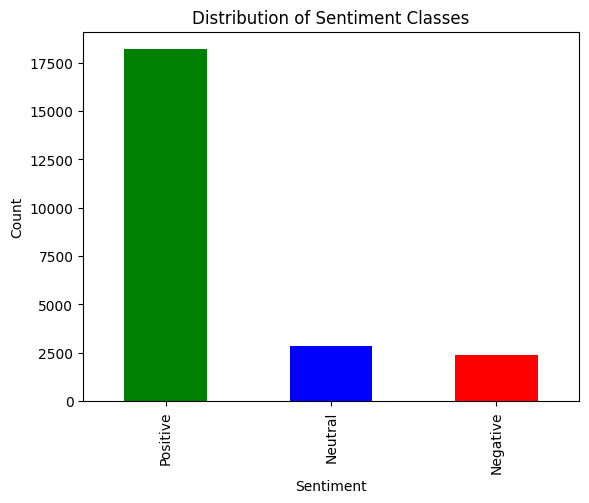

In [27]:
import matplotlib.pyplot as plt

PP_Reviews_Data['Sentiment'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [28]:
from sklearn.utils import resample

positive = PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Positive']
neutral = PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Neutral']
negative = PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Negative']


negative_upsampled = resample(negative, replace=True, n_samples=len(positive), random_state=3075)
neutral_upsampled = resample(neutral, replace=True, n_samples=len(positive), random_state=3075)


balanced_data = pd.concat([positive, neutral_upsampled, negative_upsampled])


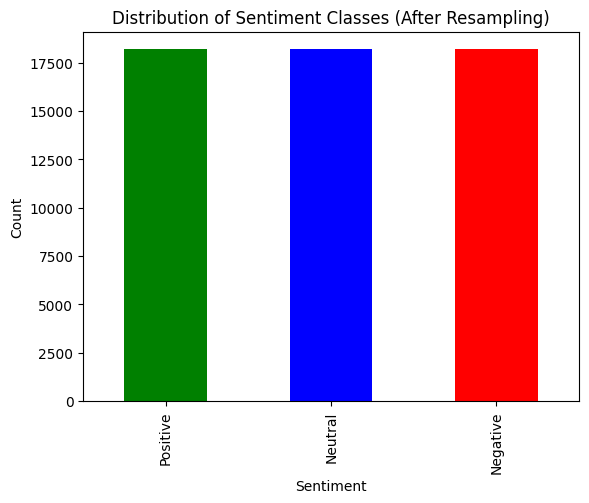

In [29]:
import matplotlib.pyplot as plt

balanced_data['Sentiment'].value_counts().plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Distribution of Sentiment Classes (After Resampling)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [30]:

print(f"Number of duplicate rows: {PP_Reviews_Data.duplicated().sum()}")

PP_Reviews_Data = PP_Reviews_Data.drop_duplicates()


Number of duplicate rows: 0


In [31]:

PP_Reviews_Data['review_length'] = PP_Reviews_Data['Review Text'].apply(len)


In [32]:

keywords = ['love', 'poor', 'excellent', 'disappointed']
for keyword in keywords:
    PP_Reviews_Data[f'has_{keyword}'] = PP_Reviews_Data['Review Text'].str.contains(keyword, case=False, na=False).astype(int)


In [34]:
PP_Reviews_Data.head()

,Id,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,cleaned_text,Sentiment,review_length,has_love,has_poor,has_excellent,has_disappointed
0,14746,0,26,Positive Feedback,Positive review but no comments.,5,1,0,General,Jackets,Outerwear,positive review comment,Positive,32,0,0,0,0
1,22742,1,50,Positive Feedback,Positive review but no comments.,5,1,0,Initmates,Intimate,Layering,positive review comment,Positive,32,0,0,0,0
2,22743,1,36,Positive Feedback,Positive review but no comments.,5,1,0,Initmates,Intimate,Layering,positive review comment,Positive,32,0,0,0,0
3,22749,1,24,Love but also very annoying,"I love this tank, it is so comfortable but it ...",2,0,1,Initmates,Intimate,Layering,love tank comfortable flaw roll every time wal...,Negative,140,1,0,0,0
4,876,2,28,Positive Feedback,Positive review but no comments.,4,1,0,General,Tops,Knits,positive review comment,Positive,32,0,0,0,0


In [37]:
print(f"Dataset contains {PP_Reviews_Data.shape[0]} rows and {PP_Reviews_Data.shape[1]} columns.")
print(PP_Reviews_Data.info())
print(PP_Reviews_Data.describe())

Dataset contains 23472 rows and 18 columns.
<class 'pandas.core.frame.DataFrame'>
Index: 23472 entries, 0 to 23485
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       23472 non-null  int64 
 1   Clothing ID              23472 non-null  int64 
 2   Age                      23472 non-null  int64 
 3   Title                    23472 non-null  object
 4   Review Text              23472 non-null  object
 5   Rating                   23472 non-null  int64 
 6   Recommended IND          23472 non-null  int64 
 7   Positive Feedback Count  23472 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
 11  cleaned_text             23472 non-null  object
 12  Sentiment                23472 non-null  object
 13  review_length            23472 non-null  int64 
 14 

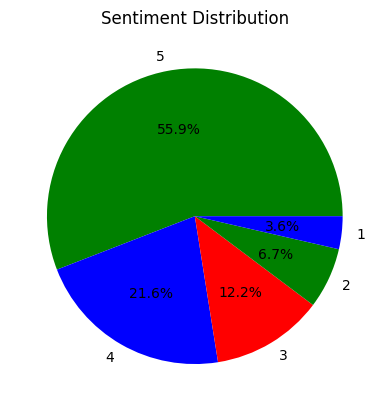

In [39]:

PP_Reviews_Data['Rating'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()


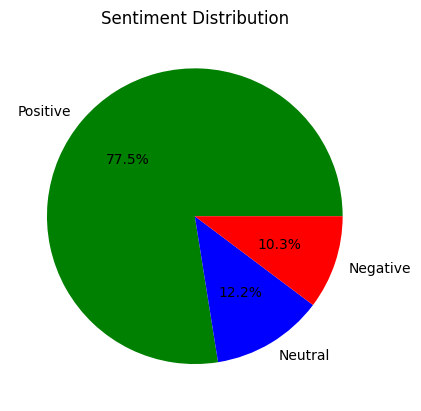

In [40]:
PP_Reviews_Data['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()


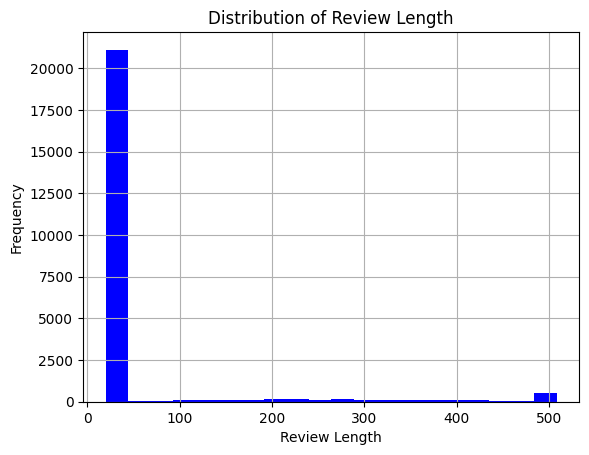

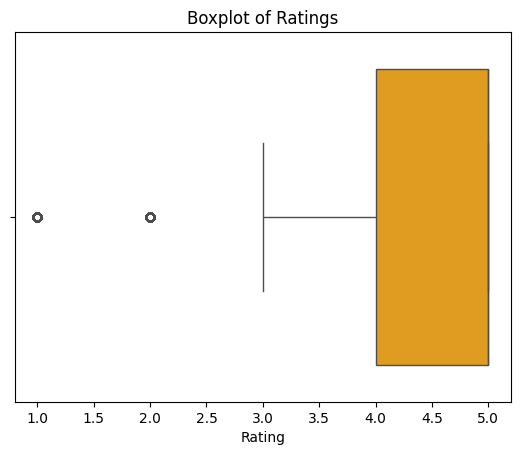

In [42]:
import seaborn as sns
# Histogram for review length
PP_Reviews_Data['review_length'].hist(bins=20, color='blue')
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Rating
sns.boxplot(data=PP_Reviews_Data, x='Rating', color='orange')
plt.title('Boxplot of Ratings')
plt.show()


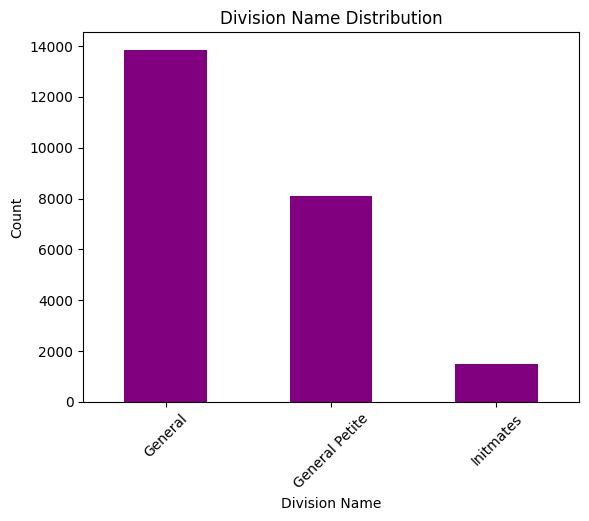

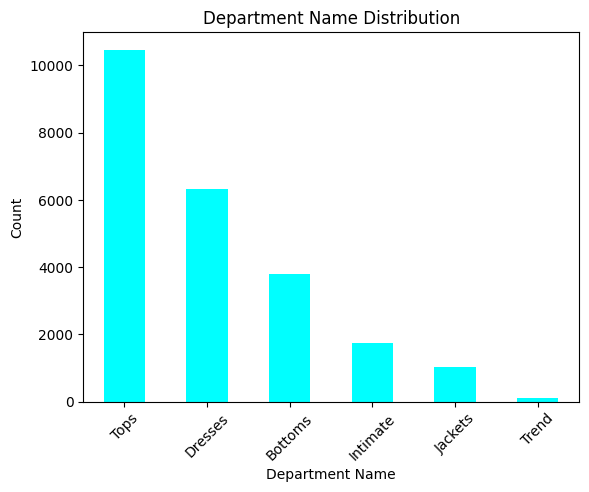

In [43]:
# Bar plot for Division Name
PP_Reviews_Data['Division Name'].value_counts().plot(kind='bar', color='purple')
plt.title('Division Name Distribution')
plt.xlabel('Division Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Bar plot for Department Name
PP_Reviews_Data['Department Name'].value_counts().plot(kind='bar', color='cyan')
plt.title('Department Name Distribution')
plt.xlabel('Department Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


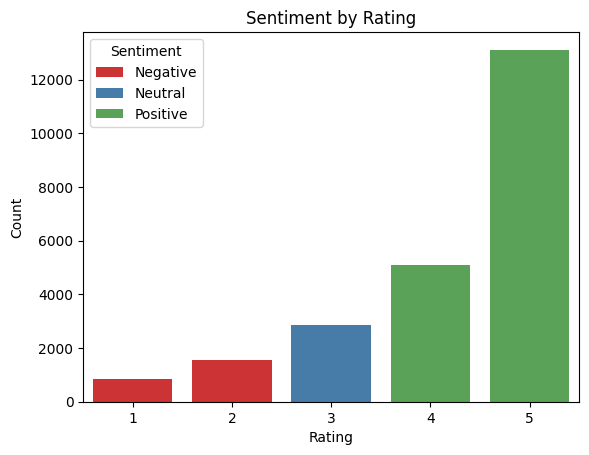

In [44]:
sns.countplot(data=PP_Reviews_Data, x='Rating', hue='Sentiment', palette='Set1')
plt.title('Sentiment by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


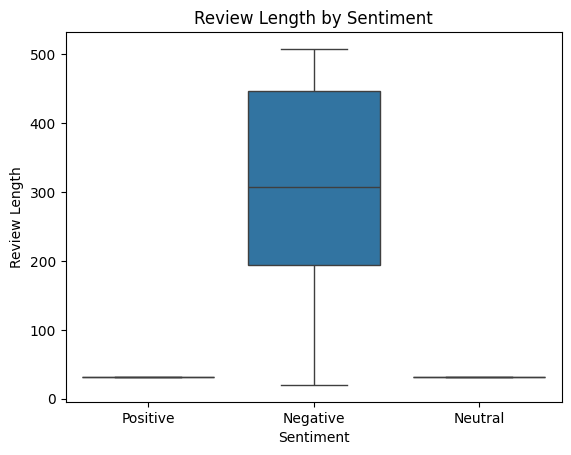

In [46]:
sns.boxplot(data=PP_Reviews_Data, x='Sentiment', y='review_length')
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()


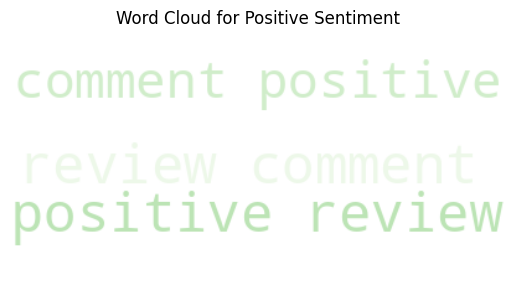

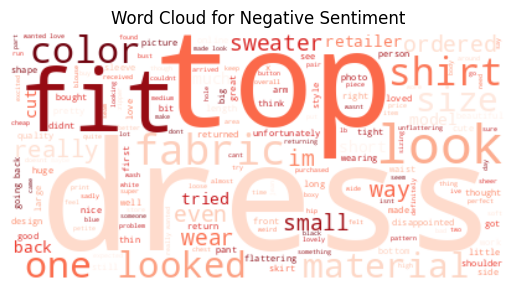

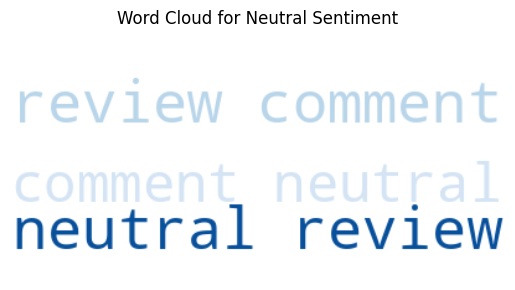

In [50]:
from wordcloud import WordCloud

# Word cloud for positive sentiment
positive_text = ' '.join(PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Positive']['cleaned_text'])
wordcloud_positive = WordCloud(background_color='white', colormap='Greens').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment')
plt.show()

# Word cloud for negative sentiment
negative_text = ' '.join(PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Negative']['cleaned_text'])
wordcloud_negative = WordCloud(background_color='white', colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment')
plt.show()

# Word cloud for Neutral sentiment
neutral_text = ' '.join(PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Neutral']['cleaned_text'])
wordcloud_neutral = WordCloud(background_color='white', colormap='Blues').generate(neutral_text)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Neutral Sentiment')
plt.show()


In [51]:
from collections import Counter


all_words = ' '.join(PP_Reviews_Data['cleaned_text']).split()
word_counts = Counter(all_words)

print(word_counts.most_common(10))


[('review', 21294), ('comment', 21111), ('positive', 18215), ('neutral', 2875), ('dress', 1201), ('like', 1050), ('look', 911), ('top', 896), ('size', 766), ('fit', 762)]


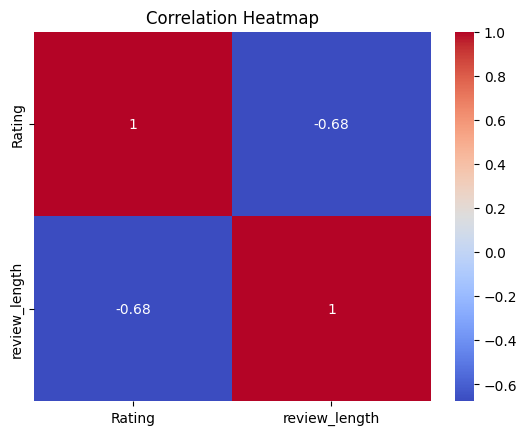

In [52]:

numerical_columns = ['Rating', 'review_length']
correlation_matrix = PP_Reviews_Data[numerical_columns].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


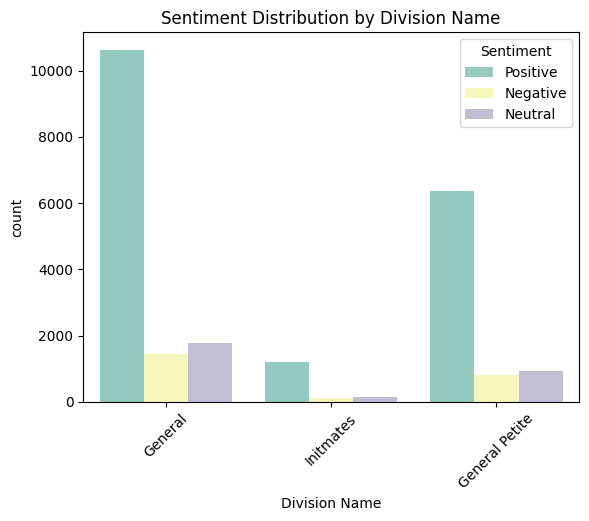

In [53]:

sns.countplot(data=PP_Reviews_Data, x='Division Name', hue='Sentiment', palette='Set3')
plt.title('Sentiment Distribution by Division Name')
plt.xticks(rotation=45)
plt.show()
